# Regression using Cyclic Boosting with High cardinality data

Cyclic Boosting performs exceptionally well in cases with high cardinality, which refers to the presence of many unique values in a dataset, such as product IDs or user IDs. High cardinality can make regression tasks challenging because it complicates the modeling process, potentially leading to overfitting or inefficiencies in capturing patterns. However, unlike most other regression methods, Cyclic Boosting conducts local optimization for each individual feature bin (which means each individual category in the case of categorical features), making it a very low-bias approach.

Examples of high cardinality:
- Sales Forecasting: Forecasting sales using product IDs or customer IDs in retail and e-commerce.

- Ad Delivery: Predicting advertising effectiveness and click-through rates based on user IDs and device IDs.

- Financial Analysis: Analyzing credit scores and loan default risk using customer accounts and transaction IDs.

- Medical Analysis: Predicting medical costs and treatment effects based on patient IDs.

- Social Media Analysis: Predicting engagement using post and user IDs.

- Traffic Prediction: Forecasting traffic volume and flight delays using vehicle IDs and operation records.

In [1]:
# Optional formatting if juypter-black is installed
try:
    import jupyter_black

    jupyter_black.load(line_length=80)
except ImportError:
    ...

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_poisson_deviance

from cyclic_boosting import flags, common_smoothers, observers
from cyclic_boosting.plots import plot_analysis
from cyclic_boosting.pipelines import pipeline_CBPoissonRegressor

from cyclic_boosting.smoothing.onedim import SeasonalSmoother, IsotonicRegressor

import lightgbm as lgb

## Load high cardinality datasets

We will conduct experiments using three simulated sales datasets with varying degrees of high cardinality for product IDs.  
The 3 datasets have been simulated such that the proportion of unique product IDs relative to the total number of records is low: 25%, moderate: 40%, and extreme: 56%.

In [3]:
import urllib.request

url_dict = {
    "low": "https://raw.githubusercontent.com/Blue-Yonder-OSS/cyclic-boosting/main/tests/high_cardinality_data/high_cardinality_data_low.csv",
    "moderate": "https://raw.githubusercontent.com/Blue-Yonder-OSS/cyclic-boosting/main/tests/high_cardinality_data/high_cardinality_data_moderate.csv",
    "extreme": "https://raw.githubusercontent.com/Blue-Yonder-OSS/cyclic-boosting/main/tests/high_cardinality_data/high_cardinality_data_extreme.csv",
}

for level, url in url_dict.items():
    urllib.request.urlretrieve(url, f"high_cardinality_data_{level}.csv")

df_low = pd.read_csv("high_cardinality_data_low.csv")
df_mod = pd.read_csv("high_cardinality_data_moderate.csv")
df_ext = pd.read_csv("high_cardinality_data_extreme.csv")

## Visualize datasets

To visualize cardinality, we will calculate the cardinality ratio for each dataset, which is the ratio of unique values in the column (in this case, the P_ID column) to the total number of data points. It is commonly accepted that if this ratio exceeds 20%, the column is considered to have high cardinality. Additionally, we will calculate the number of records contained for each product within the dataset.

In [4]:
df_datasets = pd.DataFrame(
    index=["low", "moderate", "extreme"],
    columns=[
        "n_unique_products",
        "n_records",
        "cardinality_ratio",
        "n_records_per_product_mean",
        "n_records_per_product_var",
    ],
)
for level, df in {"low": df_low, "moderate": df_mod, "extreme": df_ext}.items():
    cardinality_ratio = df["P_ID"].nunique() / len(df)
    n_records_per_product_mean = df["P_ID"].value_counts().mean()
    n_records_per_product_var = df["P_ID"].value_counts().var()
    df_datasets.loc[level] = [
        df["P_ID"].nunique(),
        len(df),
        cardinality_ratio,
        n_records_per_product_mean,
        n_records_per_product_var,
    ]

display(df_datasets)

,n_unique_products,n_records,cardinality_ratio,n_records_per_product_mean,n_records_per_product_var
low,2888,11635,0.248217,4.02874,11.995364
moderate,4841,12207,0.396576,2.521586,3.302065
extreme,6056,10749,0.563401,1.774934,1.142235


 
Here, we will display the distribution of "SALES" for each dataset and the distribution of the number of records for each product.

The left histogram depicts the frequency distribution of sales values. The x-axis represents different sales values. The y-axis indicates how frequently each sales value occurs, with a logarithmic scale. The histogram shows that the majority of sales values are low, with a steep decrease in frequency as sales values increase. This type of distribution is common in sales data, where a few high sales values are less frequent compared to many low sales values.

The right histogram displays the distribution of the number of records per product ID (P_ID). The x-axis shows the number of records, and the y-axis indicates the number of products having that specific number of records, also with a logarithmic scale. The histogram suggests that most product IDs have a lower number of records, and as the number of records increases, the frequency of such products decreases.

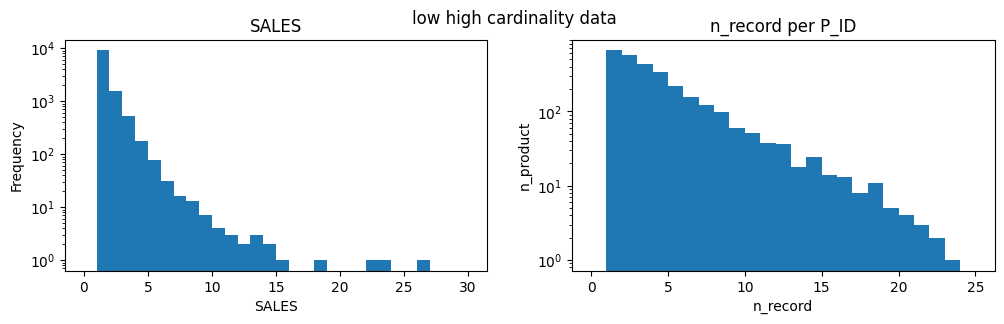

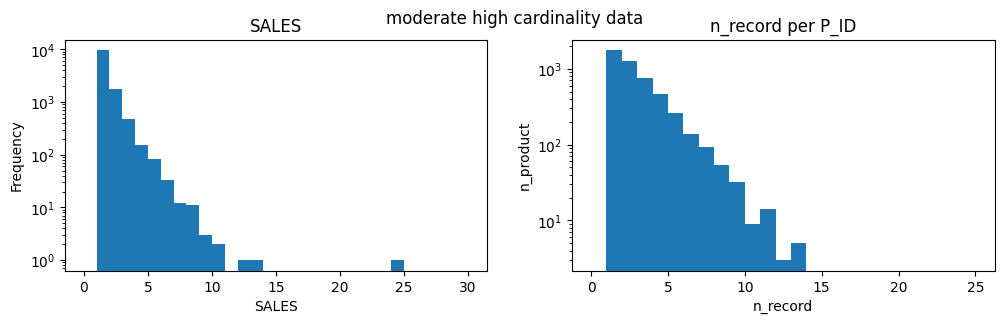

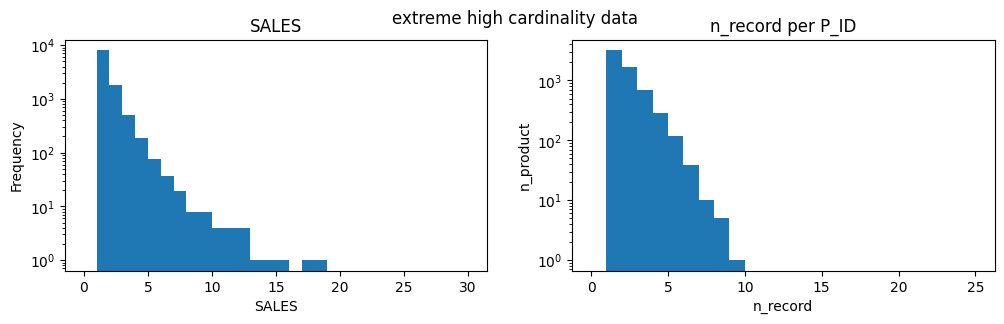

In [5]:
for level, df in {"low": df_low, "moderate": df_mod, "extreme": df_ext}.items():
    fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 3))
    fig.suptitle(f"{level} high cardinality data")
    ax1.hist(df["SALES"], log=True, bins=30, range=(0, 30))
    ax1.set_title("SALES")
    ax1.set_xlabel("SALES")
    ax1.set_ylabel("Frequency")
    ax2.hist(df["P_ID"].value_counts(), log=True, bins=25, range=(0, 25))
    ax2.set_title("n_record per P_ID")
    ax2.set_xlabel("n_record")
    ax2.set_ylabel("n_product")
    plt.show()
    plt.close()

## Prepare data

In [6]:
def prepare_data(df):
    df["DATE"] = pd.to_datetime(df["DATE"])
    df["dayofweek"] = df["DATE"].dt.dayofweek
    df["dayofyear"] = df["DATE"].dt.dayofyear

    df = df.drop(columns=["LAMBDA"])

    df["price_ratio"] = df["SALES_PRICE"] / df["NORMAL_PRICE"]
    df["price_ratio"].fillna(1, inplace=True)
    df["price_ratio"].clip(0, 1, inplace=True)
    df.loc[df["price_ratio"] == 1.0, "price_ratio"] = np.nan

    enc = OrdinalEncoder(
        handle_unknown="use_encoded_value", unknown_value=np.nan
    )
    df[["P_ID", "PG_ID_1", "PG_ID_2", "PG_ID_3", "EVENT"]] = enc.fit_transform(
        df[["P_ID", "PG_ID_1", "PG_ID_2", "PG_ID_3", "EVENT"]]
    )

    y = np.asarray(df["SALES"])
    X = df.drop(columns="SALES")

    train_size = 0.8
    split_date = (X["DATE"].max() - X["DATE"].min()) * train_size + X[
        "DATE"
    ].min()
    X_train = X.loc[X["DATE"] <= split_date]
    X_test = X.loc[X["DATE"] > split_date]
    X_train = X_train.drop(columns="DATE")
    X_test = X_test.drop(columns="DATE")
    y_train = y[X_train.index]
    y_test = y[X_test.index]
    return X_train, X_test, y_train, y_test

## Set the feature properties

In [7]:
feature_properties = {
    "P_ID": flags.IS_UNORDERED,
    "PG_ID_1": flags.IS_UNORDERED,
    "PG_ID_2": flags.IS_UNORDERED,
    "PG_ID_3": flags.IS_UNORDERED,
    "dayofweek": flags.IS_ORDERED,
    "dayofyear": flags.IS_CONTINUOUS | flags.IS_LINEAR,
    "SALES_PRICE": flags.IS_CONTINUOUS,
    "NORMAL_PRICE": flags.IS_CONTINUOUS,
    "price_ratio": flags.IS_CONTINUOUS
    | flags.HAS_MISSING
    | flags.MISSING_NOT_LEARNED,
    "PROMOTION_TYPE": flags.IS_ORDERED,
    "SCHOOL_HOLIDAY": flags.IS_UNORDERED,
    "EVENT": flags.IS_UNORDERED | flags.HAS_MISSING,
}

features = [
    "P_ID",
    "PG_ID_1",
    "PG_ID_2",
    "PG_ID_3",
    "dayofweek",
    "dayofyear",
    "SALES_PRICE",
    "NORMAL_PRICE",
    "price_ratio",
    "PROMOTION_TYPE",
    "SCHOOL_HOLIDAY",
    "EVENT",
    # interaction terms
    ("PG_ID_1", "PROMOTION_TYPE"),
    ("PG_ID_2", "PROMOTION_TYPE"),
    ("PG_ID_3", "PROMOTION_TYPE"),
    ("PG_ID_1", "dayofweek"),
    ("PG_ID_2", "dayofweek"),
    ("PG_ID_3", "dayofweek"),
    ("PG_ID_1", "SALES_PRICE"),
    ("PG_ID_2", "SALES_PRICE"),
    ("PG_ID_3", "SALES_PRICE"),
    ("PG_ID_1", "PG_ID_2"),
    ("PG_ID_1", "PG_ID_3"),
    ("PG_ID_2", "PG_ID_3"),
    ("price_ratio", "PROMOTION_TYPE"),
    ("dayofweek", "PROMOTION_TYPE"),
    ("EVENT", "PROMOTION_TYPE"),
]

## Build the model

In [8]:
def cb_poisson_regressor_model():
    explicit_smoothers = {
        ("dayofyear",): SeasonalSmoother(order=3),
        ("price_ratio",): IsotonicRegressor(increasing=False),
    }

    plobs = [
        observers.PlottingObserver(iteration=1),
        observers.PlottingObserver(iteration=-1),
    ]

    CB_pipeline = pipeline_CBPoissonRegressor(
        feature_properties=feature_properties,
        feature_groups=features,
        observers=plobs,
        maximal_iterations=50,
        smoother_choice=common_smoothers.SmootherChoiceGroupBy(
            use_regression_type=True,
            use_normalization=False,
            explicit_smoothers=explicit_smoothers,
        ),
    )

    return CB_pipeline


cb_poisson_regressor_model()

Pipeline(steps=[('binning',
                 BinNumberTransformer(feature_properties={'EVENT': 20,
                                                          'NORMAL_PRICE': 1,
                                                          'PG_ID_1': 4,
                                                          'PG_ID_2': 4,
                                                          'PG_ID_3': 4,
                                                          'PROMOTION_TYPE': 2,
                                                          'P_ID': 4,
                                                          'SALES_PRICE': 1,
                                                          'SCHOOL_HOLIDAY': 4,
                                                          'dayofweek': 2,
                                                          'dayofyear': 257,
                                                          'price_ratio': 49})),
                ('CB',
                 CBPoissonRegressor(feature_groups=['P_ID', 'PG_ID_1',
                                                    'PG_ID_2', 'PG_ID_3',
                                                    'dayofweek', 'dayofyear',
                                                    'SA...
                                    learn_rate=<function half_linear_learn_rate at 0x7f6be89be680>,
                                    maximal_iterations=50,
                                    minimal_factor_change=0.001,
                                    minimal_loss_change=0.001,
                                    observers=[<cyclic_boosting.observers.PlottingObserver object at 0x7f6be73f84c0>,
                                               <cyclic_boosting.observers.PlottingObserver object at 0x7f6be73f8d30>],
                                    smoother_choice=<cyclic_boosting.common_smoothers.SmootherChoiceGroupBy object at 0x7f6be73fa110>))])

## Training and prediction

For comparison, we will perform regression using Cyclic Boosting and Light GBM. (You need to install the lightgbm package before running.)

In [9]:
def fit_and_predict_CB(df):
    X_train, X_test, y_train, y_test = prepare_data(df)
    CB_est = cb_poisson_regressor_model()
    _ = CB_est.fit(X_train.copy(), y_train)
    yhat = CB_est.predict(X_test.copy())
    mae = np.nanmean(np.abs(y_test - yhat))
    return mae


def fit_and_predict_LGBM(df):
    X_train, X_test, y_train, y_test = prepare_data(df)
    params = {"objective": "poisson", "verbosity": -1}
    lgb_train = lgb.Dataset(X_train, y_train)
    model = lgb.train(params=params, train_set=lgb_train)
    yhat = model.predict(X_test)
    mae = np.nanmean(np.abs(y_test - yhat))
    return mae

## Compare the accuracy of Cyclic Boosting and Light GBM

In [10]:
df_mae = pd.DataFrame(
    index=["CB", "LGBM", "defference"], columns=["low", "moderate", "extreme"]
)

for level, df in {"low": df_low, "moderate": df_mod, "extreme": df_ext}.items():
    print(f"-- Processing {level} high cardinality data")
    mae_CB = fit_and_predict_CB(df)
    mae_LGBM = fit_and_predict_LGBM(df)
    df_mae[level] = [mae_CB, mae_LGBM, mae_LGBM - mae_CB]

display(df_mae)

-- Processing low high cardinality data
-- Processing moderate high cardinality data
-- Processing extreme high cardinality data


,low,moderate,extreme
CB,0.482740,0.436544,0.572737
LGBM,0.489905,0.443989,0.581132
defference,0.007165,0.007444,0.008395
